### Flows with constrained support
Often, we may know that the target distribution has constrained support. Examples could include
learning a distribution over images, in which the pixel values fall within a predefined range, or learning
a posterior over a scale parameter, which should have positive support. If the target
support is known, we can choose to ensure the flow is supported on the same set.

**Advantages of constraining the flow:** Constraining the flow prevents "leakage", where
the flow model assigns mass to regions outside the support of the target distribution.
This adds an inductive bias that often makes the target easier to learn, and ensures
valid samples for downstream applications.

**Disadvantages of constraining the flow:** If there are points very close to the
support boundary, the method for constraining/unconstraining can become unstable. In practice, for most
applications, this disadvantage can be solved with simple methods, such as applying a
small degree of clipping to the data.

We consider approximating the joint density $p(x_1, x_2)$, using toy data sampled from
the model
$$
x_1 \sim \text{Beta}(\alpha=0.3, \beta=0.3) \\
x_2 \sim N(x_2; \mu=(x_1-0.5)^3, \sigma^2=0.01^2)
$$
as $x_1$ is beta distributed, it is supported on the interval $[0, 1]$, whereas $x_2$ is supported on the real line.

Given an initially unbounded flow (i.e. supported on $\mathbb{R}^2$ ), we consider three methods for fitting
the flow.

- **No constraints**: A flow fitted without constraining the support.
- **Constrained option 1**: Transform the flow before fitting, so it has support matching the target.
- **Constrained option 2**: Transform the data to have unbounded support before fitting, matching 
the flow. After training the flow on the unbounded space, we can transform the flow such that the support matches the
original data. This approach tends to be slightly more efficient than option 1.

Importing the required libraries.

In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from paramax import non_trainable

import flowjax.bijections as bij
from flowjax.distributions import Normal, Transformed
from flowjax.flows import masked_autoregressive_flow
from flowjax.train import fit_to_data

Generating the toy data.

In [2]:
x1_key, x2_key, key = jr.split(jr.key(0), 3)
x1 = jr.beta(x1_key, a=0.3, b=0.3, shape=(1000,))
x2 = (x1-0.5)**3 + 0.01*jr.normal(x2_key, shape=x1.shape)
x = jnp.stack([x1, x2], axis=-1)

We can define a bijection to map between the unbounded space and constrained space. 
In this case, we use sigmoid to map the first dimension to $[0, 1]$, and the identity
transformation to leave the second dimension unchanged.

In [3]:
to_constrained = bij.Stack([
    bij.Sigmoid(),  # x_1: maps real -> [0, 1]
    bij.Identity(), # x_2: maps real -> real
    ])  

We can now create and train the flows, using the options outlined above.

In [4]:
key, subkey = jr.split(key)

# Create the flow
unbounded_flow = masked_autoregressive_flow(
    key=subkey,
    base_dist=Normal(jnp.zeros(x.shape[1])),
)

# Fit the flow, without applying any constraints
key, subkey = jr.split(key)
flow_no_constraints, losses = fit_to_data(
    key=subkey,
    dist=unbounded_flow,
    data=x,
    learning_rate=5e-3,
    max_patience=20,
    max_epochs=70,
)

# Contraint option 1: Transform the flow to match data support
flow_constrained_1 = Transformed(
    unbounded_flow,
    non_trainable(to_constrained) # Ensure constraint not trained!
)

# Clip for stability
x_clipped = jnp.stack([jnp.clip(x1, 1e-7, 1-1e-7), x2], axis=-1)
flow_constrained_1, losses = fit_to_data(
    key=subkey,
    dist=flow_constrained_1,
    data=x_clipped,
    learning_rate=5e-3,
    max_patience=10,
    max_epochs=70,
)

# Option 2: Transform the data to match unbounded flow support for training
x_unbounded = jax.vmap(to_constrained.inverse)(x_clipped)

flow2, losses = fit_to_data(
    key=subkey,
    dist=unbounded_flow,
    data=x_unbounded,
    learning_rate=5e-3,
    max_patience=10,
    max_epochs=70,
)
flow_constrained_2 = Transformed(flow2, to_constrained)  # Now map to constrained space

 50%|█████     | 35/70 [00:01<00:01, 28.88it/s, train=-0.0892, val=-0.01 (Max patience reached)]


We can visualise the learned densities. Without constraints, the flow leaks mass
outside the support, producing invalid samples shown in red. For higher dimensional
examples, a large proportion of samples may be from invalid regions! Both options for
constraining the flow avoid this.

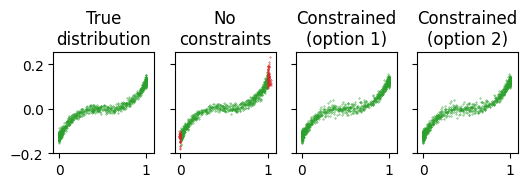

In [6]:
key, subkey = jr.split(key)
samples = {
    "True\ndistribution": x,
    "No\nconstraints": flow_no_constraints.sample(subkey, (x.shape[0],)),
    "Constrained\n(option 1)": flow_constrained_1.sample(subkey, (x.shape[0],)),
    "Constrained\n(option 2)": flow_constrained_2.sample(subkey, (x.shape[0],)),
}

fig = plt.figure(figsize=(6, 5))
axes = fig.subplots(ncols=len(samples), sharex=True, sharey=True)

for (k, v), ax in zip(samples.items(), axes, strict=True):
    is_valid = jnp.logical_and(v[:, 0] >= 0, v[:, 0] <= 1)
    ax.scatter(v[:, 0][is_valid], v[:, 1][is_valid], s=0.1, color="tab:green")
    ax.scatter(v[:, 0][~is_valid], v[:, 1][~is_valid], s=0.1, color="tab:red")
    ax.set_title(k)
    ax.set_box_aspect(1)
plt.show()